
<br>
Title: Timeseries satellite telemetry anomaly detection using an Autoencoder<br>
Author: Chuck Jackel - based on original code by Pavithra Vijay [pavithrasv](https://github.com/pavithrasv)<br>
using Vijay's tutorial from 2020 at https://keras.io/examples/timeseries/timeseries_anomaly_detection/<br>
Date created: 2022/10/6/2022<br>
Last modified: 2022/10/9/2022<br>
Description: Detect anomalies in a satellite telemetry timeseries using an Autoencoder.<br>



<br>Introduction<br>
This script demonstrates how to use a reconstruction convolutional<br>
autoencoder model to detect anomalies in timeseries satellite telemetry data.<br>



<br>Setup<br>
<br>The python hash seed and random seeds were set to ensure this code can be repeatedly executed
with the same results.<br>


In [60]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from pandas import read_csv
import tensorflow as tf
import random as python_random

PYTHONHASHSEED=0

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(222)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(222)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(333)


<br>Load the data<br><br>
Satellite bus voltage telemetry from the Laboratory for Atmospheric Sciences and Physics (LASP) at University of Colorado Boulder is used for this demonstration. The data is located on Shawn Polson's github page at https://github.com/sapols/Satellite-Telemetry-Anomaly-Detection/tree/master/Data. <br>
<br> It is unknown if any of the data is anomalous. However, there are spikes in the data that suggest possible anomalies, so the various experiments with data preparation impacted how the model performed.<br>
<br>In this demonstration, the latter 2/3 section of the original data was used to train the model. This was done to eliminate the 20 volt spike near the year 2005 as part of the training data.<br>

In [61]:
master_url_root = "https://raw.githubusercontent.com/cjackel29/ece551/"

In [62]:
#df_small_noise_url_suffix = "main/busvoltage_without_anomaly.csv"
df_small_noise_url_suffix = "main/busvoltage_smoothed_end_112707.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col=0)
df_small_noise_section = df_small_noise[:10000]
df_small_noise_original = df_small_noise
df_small_noise = df_small_noise_section

In [63]:
df_daily_jumpsup_url_suffix = "main/busvoltage_without_anomaly.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col=0)
df_daily_jumpsup_section = df_daily_jumpsup[:20009]
df_daily_jumpsup = df_daily_jumpsup_section

In [64]:
print(df_small_noise.head())
df_small_noise.shape

                     busvoltage
datetime                       
2001-01-21 21:00:00   32.003189
2001-01-22 00:00:00   31.943952
2001-01-22 03:00:00   32.102344
2001-01-22 06:00:00   31.988111
2001-01-22 09:00:00   31.945055


(10000, 1)

In [65]:
print(df_daily_jumpsup.head())
df_daily_jumpsup.shape

                     busvoltage
datetime                       
2001-01-21 21:00:00   32.003189
2001-01-22 00:00:00   31.943952
2001-01-22 03:00:00   32.102344
2001-01-22 06:00:00   31.988111
2001-01-22 09:00:00   31.945055


(20009, 1)


<br>The satellite telemetry from approximately 2008 through 2018 is used for training data.<br>


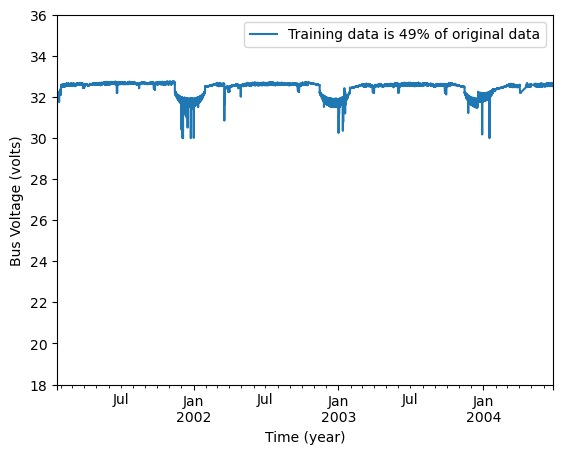

In [66]:
fig, ax = plt.subplots()
df_small_noise.plot(ax=ax)
plt.legend(["Training data is {}% of original data".format(int(100*df_small_noise.shape[0]/df_daily_jumpsup.shape[0]))])
plt.ylim(18,36)
plt.ylabel("Bus Voltage (volts)")
plt.xlabel("Time (year)")
plt.show()

<br>The entire satellite bus voltage telemetry from 2001 to 2018 has numerous spikes including a 20 volt drop near 2005. Let us see if the model will detect any of the spikes as an anomaly.<br>


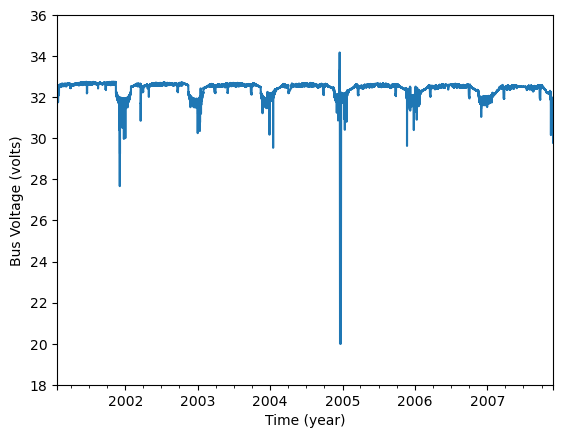

In [67]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.ylim(18,36)
plt.ylabel("Bus Voltage (volts)")
plt.xlabel("Time (year)")
plt.show()


<br>Prepare training data<br><br>
Get data values from the training timeseries data file and normalize the<br>
`value` data. We have a `value` for every 3 hours for about 18 years.<br>
-   24 hours / 3 hours = 8 timesteps per day<br>
-  8 x 365 x 18 = 52560 data points in total<br>
- Our dataset is 51704 data points, which is about 17.7 years total.<br>


Normalize the data by using the standardize method to create standard scores.<br><br>
The formula is:<br><br>
standard score = (original value - mean of entire dataset) / standard deviation of entire dataset<br>

In [68]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 10000



<br>Create sequences<br><br>
Create sequences combining `TIME_STEPS` contiguous data values from the<br>
training data.<br>


In [69]:
TIME_STEPS = 8 # each measurement is taken every 3 hours, so there are 8 samples per day, 56 samples per week, 2912 per year

Generated training sequences for use in the model.

In [70]:
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [71]:
x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (9993, 8, 1)



<br>Build a model<br><br>
We will build a convolutional reconstruction autoencoder model. The model will<br>
take input of shape `(batch_size, sequence_length, num_features)` and return<br>
output of the same shape. In this case, `sequence_length` is 8 and<br>
`num_features` is 1.<br>


In [72]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 4, 32)             256       
                                                                 
 dropout_4 (Dropout)         (None, 4, 32)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 16)             3600      
                                                                 
 conv1d_transpose_6 (Conv1DT  (None, 4, 16)            1808      
 ranspose)                                                       
                                                                 
 dropout_5 (Dropout)         (None, 4, 16)             0         
                                                                 
 conv1d_transpose_7 (Conv1DT  (None, 8, 32)            3616      
 ranspose)                                            


<br>Train the model<br><br>
Please note that we are using `x_train` as both the input and the target<br>
since this is a reconstruction model.<br>


In [73]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, mode="min")
    ],
)

Epoch 1/100
71/71 [==============================] - 1s 10ms/step - loss: 0.4240 - val_loss: 0.0174
Epoch 2/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0834 - val_loss: 0.0117
Epoch 3/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0762 - val_loss: 0.0103
Epoch 4/100
71/71 [==============================] - 1s 7ms/step - loss: 0.0733 - val_loss: 0.0093
Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0684 - val_loss: 0.0091
Epoch 6/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0643 - val_loss: 0.0088
Epoch 7/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0574 - val_loss: 0.0086
Epoch 8/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0524 - val_loss: 0.0086
Epoch 9/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0484 - val_loss: 0.0083
Epoch 10/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0445 - val_loss: 0.0081
Epoch 11

71/71 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0034
Epoch 84/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0022
Epoch 85/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0023
Epoch 86/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0025
Epoch 87/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0035
Epoch 88/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0022
Epoch 89/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0028
Epoch 90/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0030
Epoch 91/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0023
Epoch 92/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0024
Epoch 93/100



<br>
Let's plot training and validation loss to see how the training went.<br>


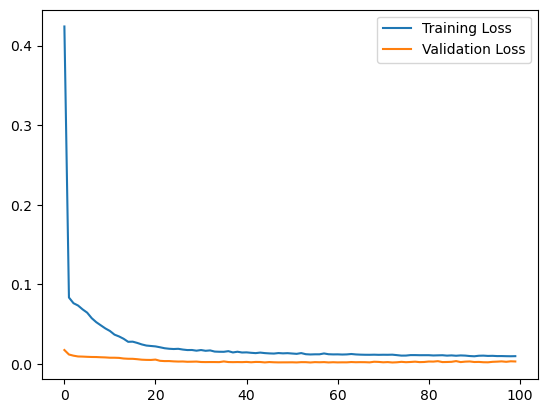

In [74]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


<br>Detecting anomalies<br><br>
We will detect anomalies by determining how well our model can reconstruct<br>
the input data.<br>
1.   Find Mean Absolute Error (MAE) loss on training samples.<br>
2.   Find max MAE loss value. This is the worst our model has performed trying<br>
to reconstruct a sample. We will make this the `threshold` for anomaly<br>
detection.<br>
3.   If the reconstruction loss for a sample is greater than this `threshold`<br>
value then we can infer that the model is seeing a pattern that it isn't<br>
familiar with. We will label this sample as an `anomaly`.<br>


Get train MAE loss.

In [75]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

313/313 [==============================] - 1s 2ms/step


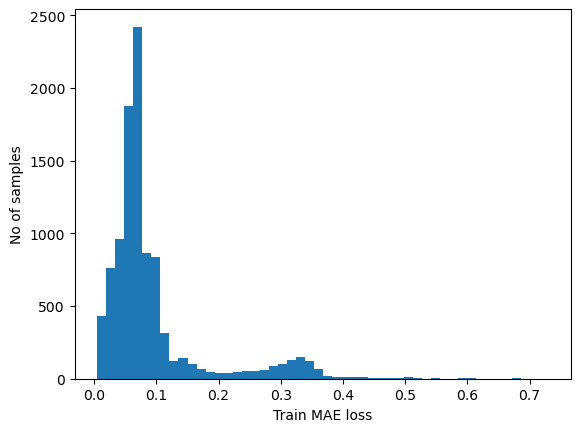

In [76]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

Get reconstruction loss threshold.

In [77]:
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.7298432344792264



<br>Compare recontruction<br>
As a test, we can see how our model has recontructed the first sample. This is the 8 timesteps in the first 24 hours of our training dataset because a measurement is recorded once every 3 hours.<br>


Checking how the first sequence is learned

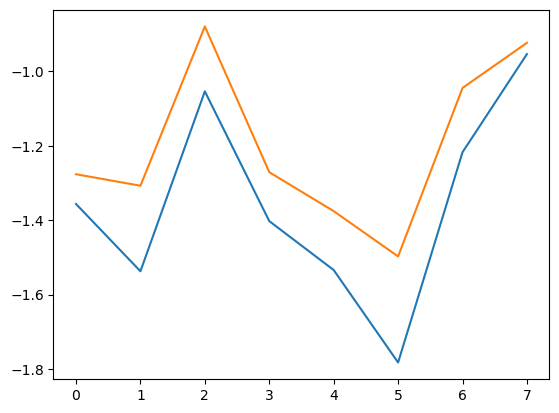

In [78]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


<br>Prepare test data<br>


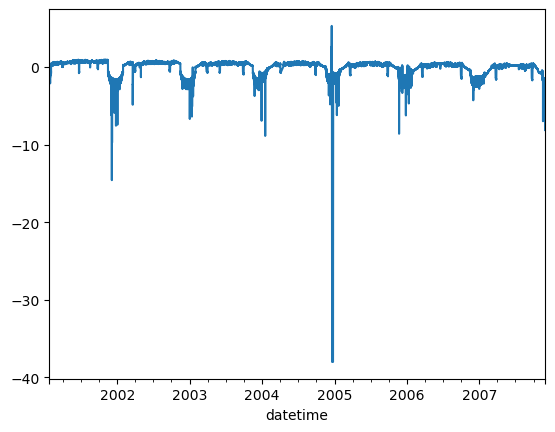

In [79]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

Create sequences from test values.

In [80]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)


Test input shape:  (20002, 8, 1)


In [81]:
x_test

array([[[-1.3562352 ],
        [-1.53712514],
        [-1.05344647],
        ...,
        [-1.7823727 ],
        [-1.21707518],
        [-0.95321807]],

       [[-1.53712514],
        [-1.05344647],
        [-1.40227654],
        ...,
        [-1.21707518],
        [-0.95321807],
        [-1.7589308 ]],

       [[-1.05344647],
        [-1.40227654],
        [-1.53375544],
        ...,
        [-0.95321807],
        [-1.7589308 ],
        [-1.27622894]],

       ...,

       [[-2.52316997],
        [-1.82543262],
        [-2.03673862],
        ...,
        [-1.93392257],
        [-1.89436042],
        [-2.38936646]],

       [[-1.82543262],
        [-2.03673862],
        [-2.65625992],
        ...,
        [-1.89436042],
        [-2.38936646],
        [-2.51844657]],

       [[-2.03673862],
        [-2.65625992],
        [-2.47201375],
        ...,
        [-2.38936646],
        [-2.51844657],
        [-8.12953015]]])

Get test MAE loss.

In [82]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

626/626 [==============================] - 1s 2ms/step


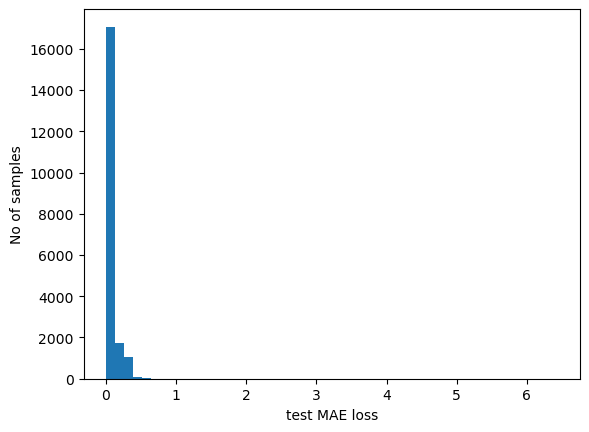

In [83]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

Detect all the samples which are anomalies.

In [84]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  35
Indices of anomaly samples:  (array([ 2528, 11394, 11395, 11396, 11397, 11398, 11399, 11400, 11401,
       11402, 11403, 11404, 11405, 11406, 11407, 11408, 11409, 11410,
       11411, 11412, 11413, 11414, 11415, 11416, 11445, 11446, 11447,
       11448, 11449, 11450, 11451, 11452, 11453, 11454, 11455]),)



<br>Plot anomalies<br><br>
We now know the samples of the data which are anomalies. With this, we will<br>
find the corresponding `timestamps` from the original test data. We will be<br>
using the following method to do that:<br><br>
Let's say time_steps = 3 and we have 10 training values. Our `x_train` will<br>
look like this:<br>
- 0, 1, 2<br>
- 1, 2, 3<br>
- 2, 3, 4<br>
- 3, 4, 5<br>
- 4, 5, 6<br>
- 5, 6, 7<br>
- 6, 7, 8<br>
- 7, 8, 9<br><br>
All except the initial and the final time_steps-1 data values, will appear in<br>
`time_steps` number of samples. So, if we know that the samples<br>
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point<br>
5 is an anomaly.<br>


data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies

In [85]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
if len(anomalous_data_indices) == 0:
    print("No anomalies detected by model.")



<br>We can overlay the anomalies on the original test data plot shown in red.<br>


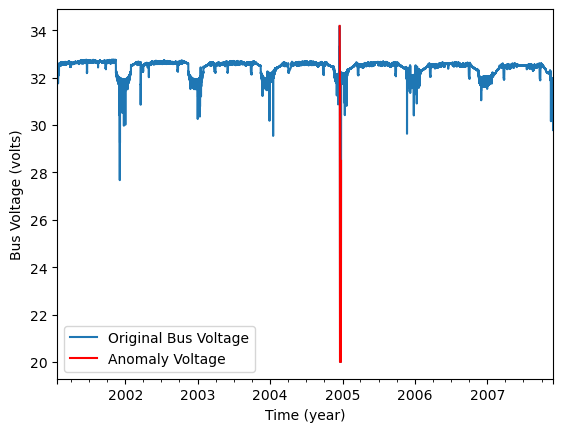

In [86]:
if len(anomalous_data_indices) > 0:
    df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
    df_subset.columns=["Anomaly Voltage"]
    df_daily_jumpsup.columns=["Original Bus Voltage"]
    fig, ax = plt.subplots()
    df_daily_jumpsup.plot(ax=ax) # removed legend=False
    df_subset.plot(ax=ax, color="r")
    plt.legend()
    plt.ylabel("Bus Voltage (volts)")
    plt.xlabel("Time (year)")
    plt.show()

In [87]:
anomalous_data_indices

[11401,
 11402,
 11403,
 11404,
 11405,
 11406,
 11407,
 11408,
 11409,
 11410,
 11411,
 11412,
 11413,
 11414,
 11415,
 11416,
 11417,
 11452,
 11453,
 11454,
 11455,
 11456]

In [88]:
df_subset

,Anomaly Voltage
datetime,
2004-12-17 00:00:00,34.180000
2004-12-17 03:00:00,33.893214
2004-12-17 06:00:00,33.606428
2004-12-17 09:00:00,33.319643
2004-12-17 12:00:00,33.032857
2004-12-17 15:00:00,32.746071
2004-12-17 18:00:00,32.459285
2004-12-17 21:00:00,32.172500
2004-12-18 00:00:00,30.650937
